In [190]:
import os
import numpy as np
import torch
from torch.optim import Adam
from torchvision import models
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
# from misc_functions import preprocess_image, recreate_image, save_image
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


class Net(nn.Module):
    def __init__(self,):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 9)
        self.conv2 = nn.Conv2d(32, 32, 5)
        self.norm = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(7, 7)
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout2d(p=0.2)
#         self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,50)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.norm(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x


In [191]:
model = torch.load("../CNN_Non_Hierarchical.pt")
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(9, 9), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=50, bias=True)
  (softmax): Softmax(dim=None)
)


In [158]:
print(*list(model.children()))

Conv2d(1, 32, kernel_size=(9, 9), stride=(1, 1)) Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1)) BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) MaxPool2d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False) Linear(in_features=256, out_features=128, bias=True) Dropout2d(p=0.2, inplace=False) Linear(in_features=128, out_features=64, bias=True) Linear(in_features=64, out_features=50, bias=True) Softmax(dim=None)


## Visualize CNN Filters

<IPython.core.display.Javascript object>


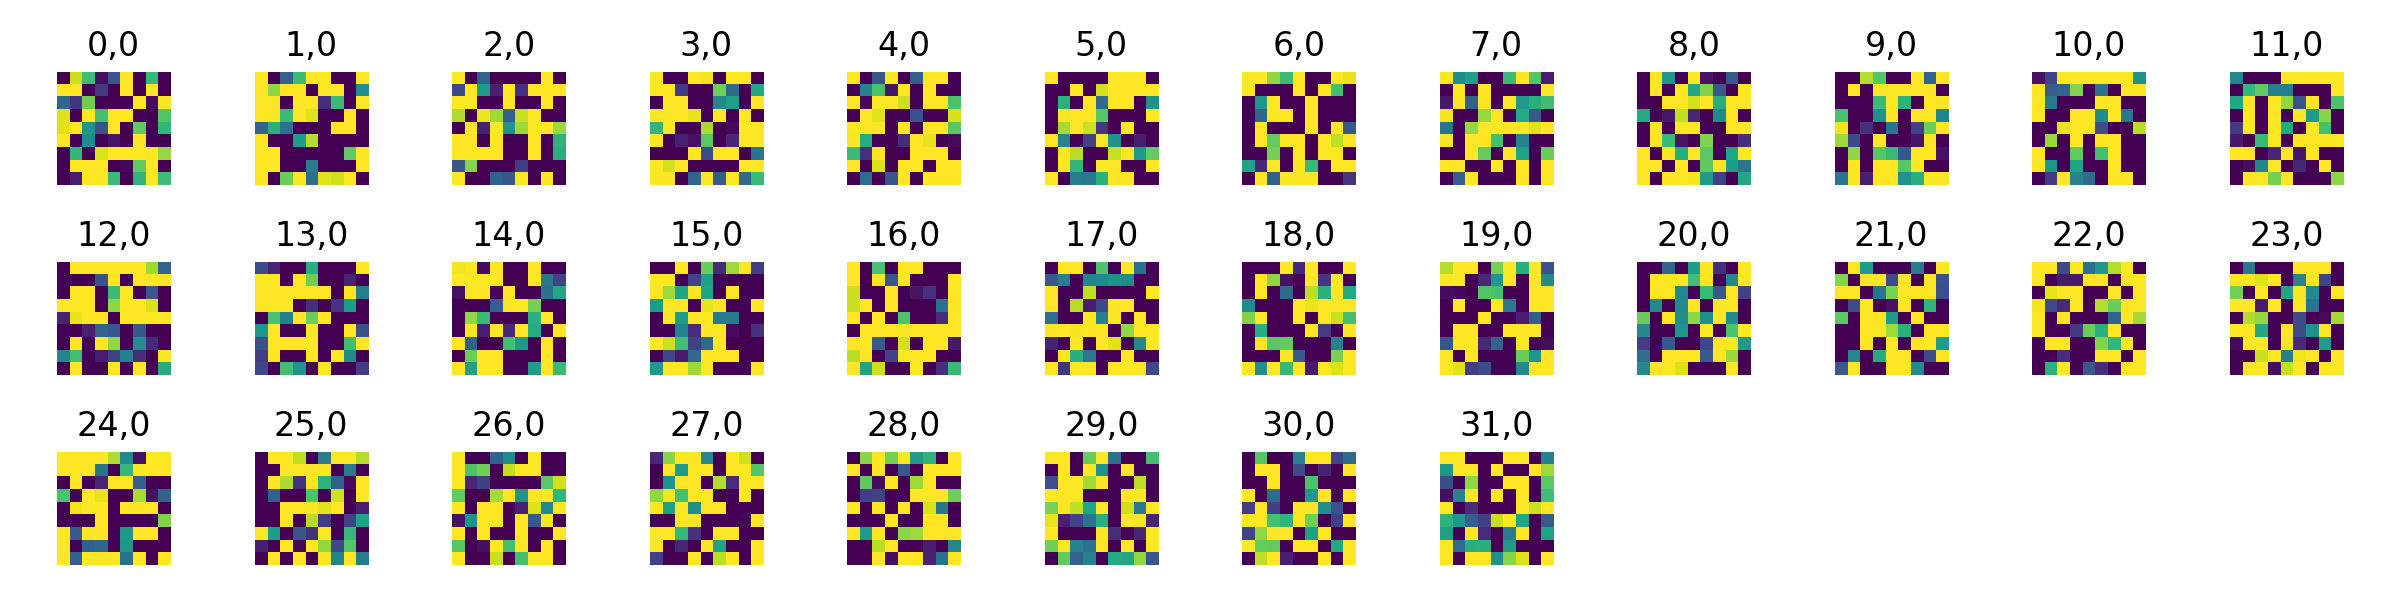

In [6]:
from vis_filters import *
plot_weights(model, 0, single_channel = True)

## Gradient * Image

### 1. Vanilla Gradient

In [26]:
class VanillaBackprop():
    """
        Produces gradients generated with vanilla back propagation from the image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        # Hook the first layer to get the gradient
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer
        first_layer = weight_tensor = nn.Sequential(*list(model.children())[:4])[0]
#         first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def generate_gradients(self, input_image, target_class):
        model_output = self.model(input_image)
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

In [40]:
def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale
    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im

In [196]:
def save_gradient_images(gradient, file_name="", grayscale=True):
    """
        Exports the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    path_to_file = os.path.join('../output/', file_name + '.jpg')
    gradient = gradient[0,:,:]
    if grayscale:
        plt.imshow(gradient, cmap='gray')
    else:
        plt.imshow(gradient)
    plt.savefig(path_to_file)

    return gradient

/Users/xixi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<IPython.core.display.Javascript object>


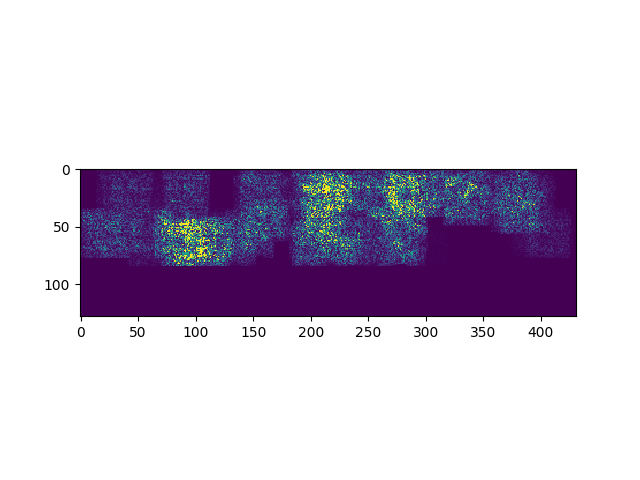

In [198]:
def get_example_params():
    
    example_list = ['../input_images/1-51805-C-33.npy',
                    '../input_images/1-51805-D-33.npy',
                    '../input_images/5-161270-B-33.npy']

    for filepath in example_list:
        prep_img = np.load(filepath)
        target_class = 33
    
    return (prep_img, target_class)


output_dir = "../output/"
prep_img, target_class =get_example_params()
prep_img = np.expand_dims(prep_img, axis=0)
prep_img = np.expand_dims(prep_img, axis=0)
prep_img = torch.from_numpy(prep_img)
prep_img = Variable(prep_img, requires_grad=True)
VBP = VanillaBackprop(model)
vanilla_grads = VBP.generate_gradients(prep_img, target_class)
grad_times_image = vanilla_grads[0] * prep_img.detach().numpy()[0]
grayscale_vanilla_grads = convert_to_grayscale(grad_times_image)

im = save_gradient_images(grayscale_vanilla_grads,'Vanilla_grad_times_image_gray_color', False)

### 2. Guided Gradient

In [193]:
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = weight_tensor = nn.Sequential(*list(model.children())[:4])[0]
#         first_layer = list(self.model.features._modules.items())[0][1]
#         first_layer.register_backward_hook(hook_function)
    
#         first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):

        def relu_backward_hook_function(module, grad_in, grad_out):
   
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output = corresponding_forward_output[0]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):

            self.forward_relu_outputs.append(ten_in)

        # Loop through layers, hook up ReLUs
#         first_layer = weight_tensor = nn.Sequential(*list(model.children())[:4])[0]
#         first_layer = list(self.model.features._modules.items())[0][1]
#         first_layer.register_backward_hook(hook_function)
        for module in nn.Sequential(*list(model.children())):
#             print(module)
            if isinstance(module, nn.MaxPool2d):
                module.register_forward_hook(relu_forward_hook_function)
                module.register_backward_hook(relu_backward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

In [199]:
target_example = 33  # Snake
# (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
#     get_example_params(target_example)
prep_img, target_class =get_example_params()
prep_img = np.expand_dims(prep_img, axis=0)
prep_img = np.expand_dims(prep_img, axis=0)
prep_img = torch.from_numpy(prep_img)
prep_img = Variable(prep_img, requires_grad=True)
# Guided backprop
GBP = GuidedBackprop(model)
# Get gradients
guided_grads = GBP.generate_gradients(prep_img, target_class)
guided_grads = convert_to_grayscale(guided_grads)
# Save colored gradients
save_gradient_images(guided_grads, '_Guided_BP_color', False)
# # Convert to grayscale
# grayscale_guided_grads = convert_to_grayscale(guided_grads)
# # Save grayscale gradients
# save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
# # Positive and negative saliency maps
# pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
# save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
# save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
# print('Guided backprop completed')

/Users/xixi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [2]:
class CNNLayerVisualization():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        # Create the folder to export images if not exists
        if not os.path.exists('../generated'):
            os.makedirs('../generated')

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]
        # Hook the selected layer
        _ = nn.Sequential(*list(self.model.children())[:1])[0]
        _.register_forward_hook(hook_function)
        # self.model[self.selected_layer].register_forward_hook(hook_function)

    def visualise_layer_with_hooks(self):
        # Hook the selected layer
        self.hook_layer()
        # Generate a random image
        random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 1)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image
            for index, layer in enumerate(self.model.children()):
                # Forward pass layer by layer
                # x is not used after this point because it is only needed to trigger
                # the forward hook function
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    # (forward hook function triggered)
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
            # Save image
            if i % 5 == 0:
                im_path = '../generated/layer_vis_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
                im = self.created_image[:,:,0]
#                 im = plt.imshow(self.created_image[:,:,0], cmap='gray')
                plt.imshow(im, cmap='gray', vmin=0, vmax=255)
#                 plt.savefig("./d{}.png".format(i))
#                 self.created_image.plot()
#                 save_image(self.created_image, im_path)

    def visualise_layer_without_hooks(self):
        # Process image and return variable
        # Generate a random image
        random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                x = layer(x)
                if index == self.selected_layer:
                    # Only need to forward until the selected layer is reached
                    # Now, x is the output of the selected layer
                    break
            # Here, we get the specific filter from the output of the convolution operation
            # x is a tensor of shape 1x512x28x28.(For layer 17)
            # So there are 512 unique filter outputs
            # Following line selects a filter from 512 filters so self.conv_output will become
            # a tensor of shape 28x28
            self.conv_output = x[0, self.selected_filter]
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
            # Save image
            if i % 5 == 0:
                im_path = '../generated/layer_vis_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
                save_image(self.created_image, im_path)


Iteration: 1 Loss: 0.39
Iteration: 2 Loss: 0.35
Iteration: 3 Loss: 0.31
Iteration: 4 Loss: 0.27
Iteration: 5 Loss: 0.23


<IPython.core.display.Javascript object>


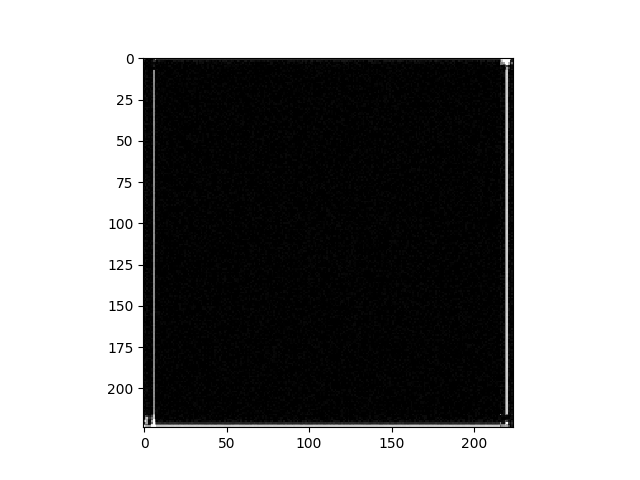

Iteration: 6 Loss: 0.19
Iteration: 7 Loss: 0.15
Iteration: 8 Loss: 0.11
Iteration: 9 Loss: 0.07
Iteration: 10 Loss: 0.03
Iteration: 11 Loss: -0.01
Iteration: 12 Loss: -0.05
Iteration: 13 Loss: -0.09
Iteration: 14 Loss: -0.12
Iteration: 15 Loss: -0.16
Iteration: 16 Loss: -0.20
Iteration: 17 Loss: -0.24
Iteration: 18 Loss: -0.28
Iteration: 19 Loss: -0.32
Iteration: 20 Loss: -0.35
Iteration: 21 Loss: -0.39
Iteration: 22 Loss: -0.43
Iteration: 23 Loss: -0.47
Iteration: 24 Loss: -0.50
Iteration: 25 Loss: -0.54
Iteration: 26 Loss: -0.58
Iteration: 27 Loss: -0.62
Iteration: 28 Loss: -0.65
Iteration: 29 Loss: -0.69
Iteration: 30 Loss: -0.72


In [3]:

cnn_layer = 1
filter_pos = 5
# Fully connected layer is not needed
pretrained_model = torch.load("../CNN_Non_Hierarchical.pt")
# pretrained_model = models.vgg16(pretrained=True).features
layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)

# Layer visualization with pytorch hooks
layer_vis.visualise_layer_with_hooks()

# Layer visualization without pytorch hooks
# layer_vis.visualise_layer_without_hooks()
